In [1]:
import numpy as np
import pandas as pd
import icecream
import math
import sklearn
import os
import time
import gc
import random
import re
import csv
# import spacy
import torch
import torchtext
# from torchtext.datasets import IMDB
from torch import Tensor
import torch.nn as nn
# from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F
from torch.utils.data import dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from itertools import *
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
# from sklearn.cluster import AgglomerativeClustering
# from scipy.cluster.hierarchy import dendrogram
# from tempfile import TemporaryDirectory
from typing import Tuple

from Suicide_Experiment.D_sensitivity_scores_svm import threshold
from captum.concept import TCAV
# from captum.concept import Concept
from captum.concept._utils.common import concepts_to_str
# import torchdata.datapipes as dp
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr._core.layer.layer_activation import LayerActivation 
# from suicidedataset import SuicideDataSet, bert_tokenizer
# from sklearn.cluster import MiniBatchKMeans
# from PIL import Image
# from wordcloud import WordCloud
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sucideClassifier import TextClassificationModel
import pickle
from tqdm import tqdm


C:\Users\salma\anaconda3\envs\env-gpu-10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
files_dir = "../Suicide_files"
SENSITIVITY_DIR = os.path.join(files_dir, "sensitivity")
GRADIENTS_DIR = os.path.join(files_dir, "gradients")
CAVS_DIR = os.path.join(files_dir, "CAVs")
TCAVQ_DIR = os.path.join(files_dir, "tcavscores")
CLASSES_LIST = ["pos", "neg"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Find Concepts with highest and lowest scores for each class

In [33]:
sensitivity_scores_df_pd_pc = pd.read_csv(os.path.join(SENSITIVITY_DIR,"pos","sensitivity_scores_pos_data_pos_concepts_faster.csv"), header=None)
sensitivity_scores_df_pd_nc = pd.read_csv(os.path.join(SENSITIVITY_DIR,"pos","sensitivity_scores_pos_data_neg_concepts_faster.csv"), header=None)
sensitivity_scores_df_nd_pc = pd.read_csv(os.path.join(SENSITIVITY_DIR,"neg","sensitivity_scores_neg_data_pos_concepts_faster.csv"), header=None)
# sensitivity_scores_df.set_index(0, inplace=True)
sensitivity_scores_df_nd_nc = pd.read_csv(os.path.join(SENSITIVITY_DIR,"neg","sensitivity_scores_neg_data_neg_concepts_faster.csv"), header=None)
# sensitivity_scores_df.set_index(0, inplace=True)

In [34]:
# extra_settings = "_threshold12"
# extra_settings = ""
extra_settings = "_multi"
postcav = pd.read_csv(os.path.join(TCAVQ_DIR,f'pos/tcavscores{extra_settings}.csv'))
postcav = postcav.set_index('Concept')
negtcav = pd.read_csv(os.path.join(TCAVQ_DIR,f'neg/tcavscores{extra_settings}.csv'))
negtcav = negtcav.set_index('Concept')
postcav.head()

,random_state,pos_tcavq,neg_tcavq,samples,pos_sens_sum,neg_sens_sum,pos_log_tcav,neg_log_tcav
Concept,,,,,,,,
0,42,10177,104,10180,3.686341e-07,-0.000001,104.049580,4.65396
1,42,10177,104,10180,9.904991e-05,0.000095,106.015516,4.65396
2,42,10177,104,10180,1.968640e-04,0.000195,104.361342,4.65396
3,42,10177,104,10180,2.959310e-04,0.000291,104.390233,4.65396
4,42,10177,104,10180,3.955080e-04,0.000386,104.261624,4.65396


In [35]:
threshold = 10**(-7)
postcav['pos_tcavq_t-7'] = [len(np.where(sensitivity_scores_df_pd_pc[concept_col]>threshold)[0]) for concept_col in sensitivity_scores_df_pd_pc.columns]
postcav['neg_tcavq_t-7'] =[len(np.where(sensitivity_scores_df_nd_pc[concept_col]>threshold)[0]) for concept_col in sensitivity_scores_df_nd_pc.columns]
postcav.head()

,random_state,pos_tcavq,neg_tcavq,samples,pos_sens_sum,neg_sens_sum,pos_log_tcav,neg_log_tcav,pos_tcavq_t-7,neg_tcavq_t-7
Concept,,,,,,,,,,
0,42,10177,104,10180,3.686341e-07,-0.000001,104.049580,4.65396,1360,0
1,42,10177,104,10180,9.904991e-05,0.000095,106.015516,4.65396,1703,0
2,42,10177,104,10180,1.968640e-04,0.000195,104.361342,4.65396,1342,0
3,42,10177,104,10180,2.959310e-04,0.000291,104.390233,4.65396,1996,0
4,42,10177,104,10180,3.955080e-04,0.000386,104.261624,4.65396,2496,0


In [42]:
threshold = 10**(-7)
negtcav['pos_tcavq_t-7'] = [len(np.where(sensitivity_scores_df_pd_nc[concept_col]>threshold)[0]) for concept_col in sensitivity_scores_df_pd_nc.columns]
negtcav['neg_tcavq_t-7'] =[len(np.where(sensitivity_scores_df_nd_nc[concept_col]>threshold)[0]) for concept_col in sensitivity_scores_df_nd_nc.columns]
negtcav.head()

,random_state,pos_tcavq,neg_tcavq,samples,pos_sens_sum,neg_sens_sum,neg_log_tcav,pos_log_tcav,pos_tcavq_t-7,neg_tcavq_t-7
Concept,,,,,,,,,,
0,42,0,3646,10180,-2.450000e-06,0.000008,48.698893,0,0,3532
2,42,0,3646,10180,-8.540000e-07,0.000003,48.674781,0,0,3525
3,42,0,3646,10180,-2.070000e-06,0.000006,50.586082,0,0,3532
4,42,0,3646,10180,-1.350000e-06,0.000005,48.367403,0,0,3528
5,42,0,3646,10180,-2.330000e-06,0.000008,48.684201,0,0,3532


In [36]:
postcav['neg_tcavq_t-7'].max()

3474

In [39]:
posconceptscoresposdata = {f"pos_{concept}": postcav.loc[concept]['pos_tcavq_t-7']/postcav.loc[concept]['samples'] for concept in postcav.index }
posconceptscoresnegdata= {f"pos_{concept}": postcav.loc[concept]['neg_tcavq_t-7']/postcav.loc[concept]['samples'] for concept in postcav.index }
posconceptscoresposdata = sorted(posconceptscoresposdata.items(), key=lambda x: x[1], reverse=True)
posconceptscoresnegdata = sorted(posconceptscoresnegdata.items(), key=lambda x: x[1], reverse=True)
posconceptscoresnegdata
# posconceptscoresposdata

[('pos_53', 0.3412573673870334),
 ('pos_118', 0.31355599214145385),
 ('pos_197', 0.29351669941060904),
 ('pos_145', 0.2865422396856582),
 ('pos_136', 0.2786836935166994),
 ('pos_86', 0.2595284872298625),
 ('pos_271', 0.25333988212180747),
 ('pos_62', 0.24793713163064832),
 ('pos_80', 0.24361493123772102),
 ('pos_202', 0.23988212180746563),
 ('pos_90', 0.23713163064833007),
 ('pos_13', 0.23536345776031434),
 ('pos_450', 0.22838899803536344),
 ('pos_584', 0.2181728880157171),
 ('pos_209', 0.21709233791748528),
 ('pos_182', 0.21650294695481337),
 ('pos_126', 0.21345776031434185),
 ('pos_203', 0.1899803536345776),
 ('pos_238', 0.18290766208251474),
 ('pos_148', 0.17455795677799607),
 ('pos_123', 0.14911591355599213),
 ('pos_310', 0.143713163064833),
 ('pos_550', 0.14007858546168958),
 ('pos_556', 0.13536345776031433),
 ('pos_290', 0.12573673870333987),
 ('pos_169', 0.10717092337917486),
 ('pos_194', 0.09724950884086445),
 ('pos_422', 0.058742632612966604),
 ('pos_142', 0.05569744597249509)

In [43]:
negconceptscoresposdata = {f"pos_{concept}": negtcav.loc[concept]['pos_tcavq_t-7']/negtcav.loc[concept]['samples'] for concept in negtcav.index }
negconceptscoresnegdata= {f"pos_{concept}": negtcav.loc[concept]['neg_tcavq_t-7']/negtcav.loc[concept]['samples'] for concept in negtcav.index }
negconceptscoresposdata = sorted(negconceptscoresposdata.items(), key=lambda x: x[1], reverse=True)
negconceptscoresnegdata = sorted(negconceptscoresnegdata.items(), key=lambda x: x[1], reverse=True)
# posconceptscoresnegdata
negconceptscoresnegdata

[('pos_144', 0.3568762278978389),
 ('pos_79', 0.35343811394891944),
 ('pos_18', 0.35333988212180745),
 ('pos_77', 0.35333988212180745),
 ('pos_103', 0.35333988212180745),
 ('pos_71', 0.3532416502946955),
 ('pos_324', 0.3532416502946955),
 ('pos_8', 0.3470530451866405),
 ('pos_11', 0.3470530451866405),
 ('pos_32', 0.3470530451866405),
 ('pos_34', 0.3470530451866405),
 ('pos_46', 0.3470530451866405),
 ('pos_57', 0.3470530451866405),
 ('pos_74', 0.3470530451866405),
 ('pos_88', 0.3470530451866405),
 ('pos_91', 0.3470530451866405),
 ('pos_149', 0.3470530451866405),
 ('pos_167', 0.3470530451866405),
 ('pos_231', 0.3470530451866405),
 ('pos_0', 0.3469548133595285),
 ('pos_3', 0.3469548133595285),
 ('pos_5', 0.3469548133595285),
 ('pos_17', 0.3469548133595285),
 ('pos_21', 0.3469548133595285),
 ('pos_24', 0.3469548133595285),
 ('pos_42', 0.3469548133595285),
 ('pos_49', 0.3469548133595285),
 ('pos_52', 0.3469548133595285),
 ('pos_68', 0.3469548133595285),
 ('pos_72', 0.3469548133595285),
 ('p

# Plotting Concept Rankings

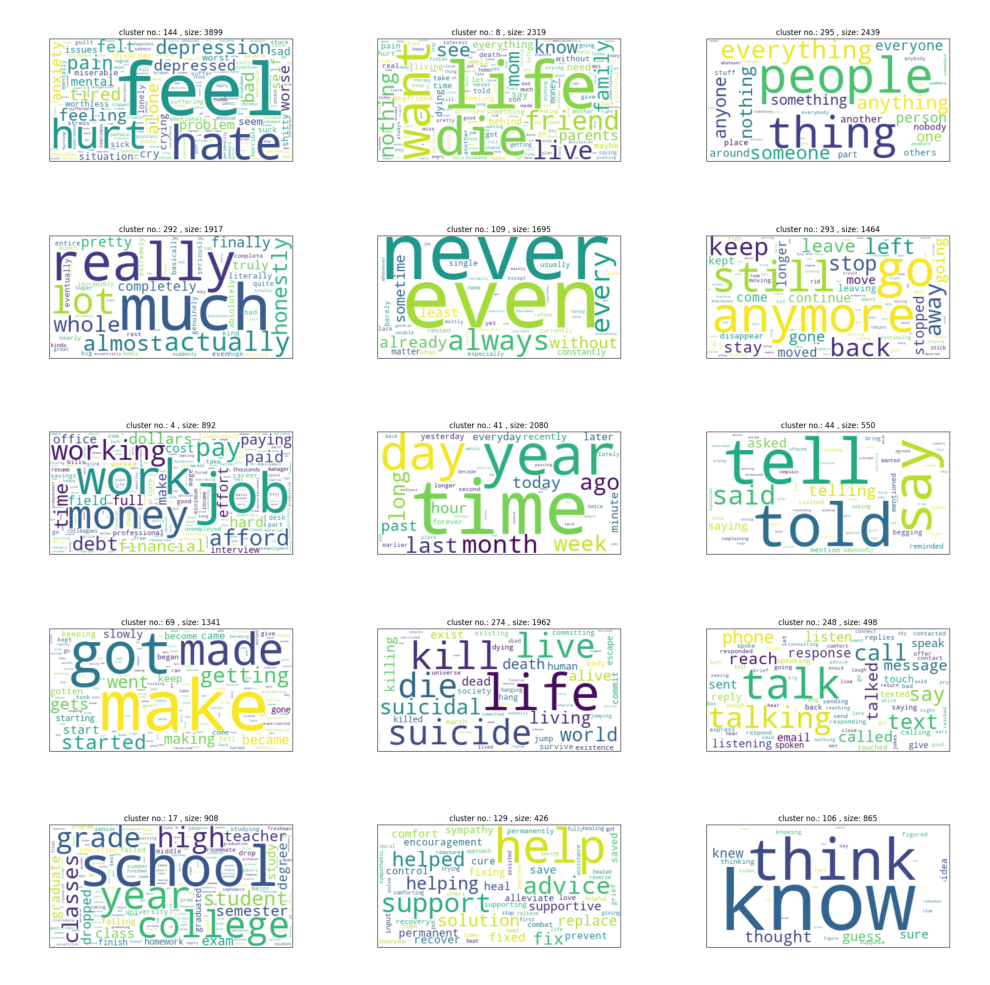

In [44]:
from PIL import Image
import matplotlib.pyplot as plt
def load_concept_wordcloud(paths):
    """
    Load a word cloud image for a given concept name.
    """
    num_images = len(paths)
    if num_images == 0:
        raise ValueError("No images found for the given concept name.")
    grid_dimensions = (math.ceil(num_images / 3), 3)  # Create a grid of subplots
    fig, axes = plt.subplots(*grid_dimensions, figsize=(10, 2 * grid_dimensions[0]))
    # fig, axes = plt.subplots(5, 2, figsize=(10, 15))
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration
    for ax, img_path in zip(axes, image_paths):
        img = Image.open(os.path.join(files_dir,img_path))
        ax.imshow(img)
        ax.axis('off')  # Hide axes
    plt.tight_layout()
    plt.show()

  
# File paths for the images
image_paths = [
    f'word_clouds/pos/cosine/average/600/white/clus_{clusternum.split("_")[1]}.png' for (clusternum, _) in posconceptscoresposdata[:15]
]
load_concept_wordcloud(image_paths)


# Load and display the images in a 3 by 2 grid


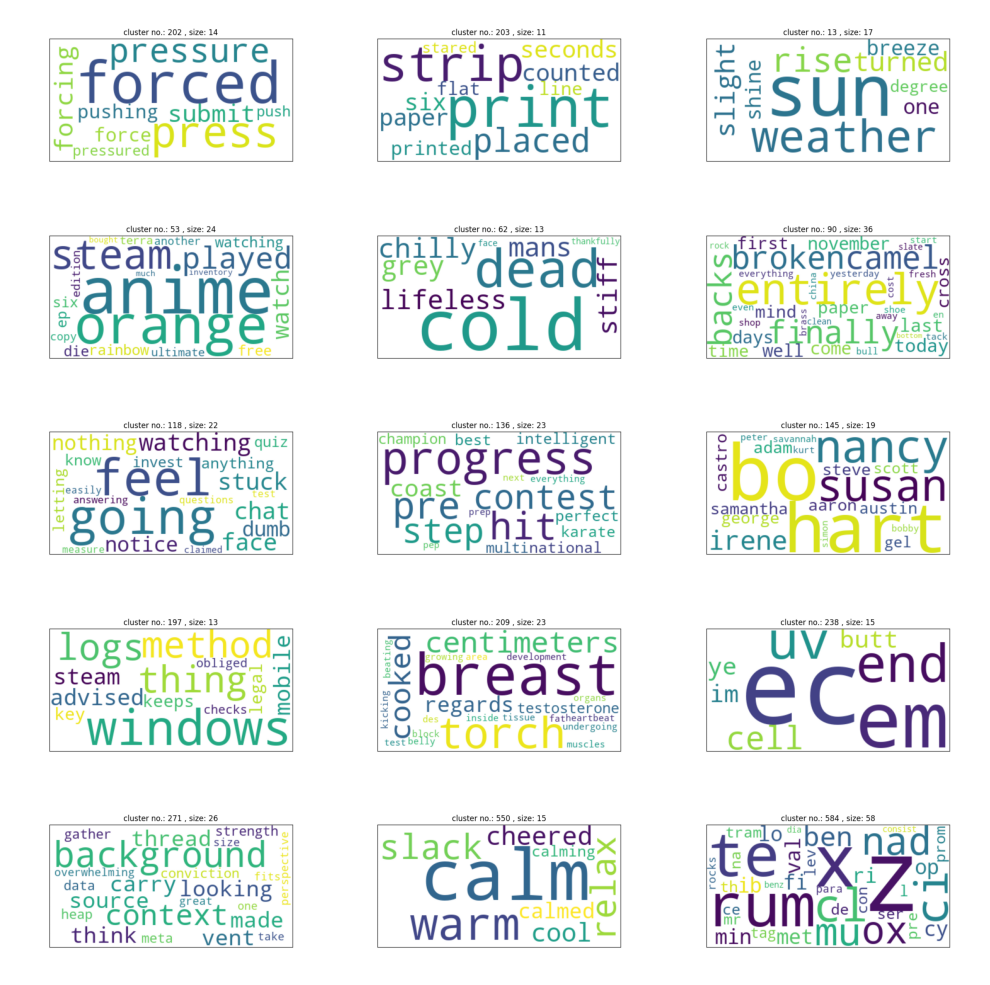

In [45]:
import matplotlib.pyplot as plt
from PIL import Image

# File paths for the images
image_paths = [
    f'word_clouds/pos/cosine/average/600/white/clus_{clusternum.split("_")[1]}.png' for (clusternum, _) in posconceptscoresposdata[-15:]
]

load_concept_wordcloud(image_paths)

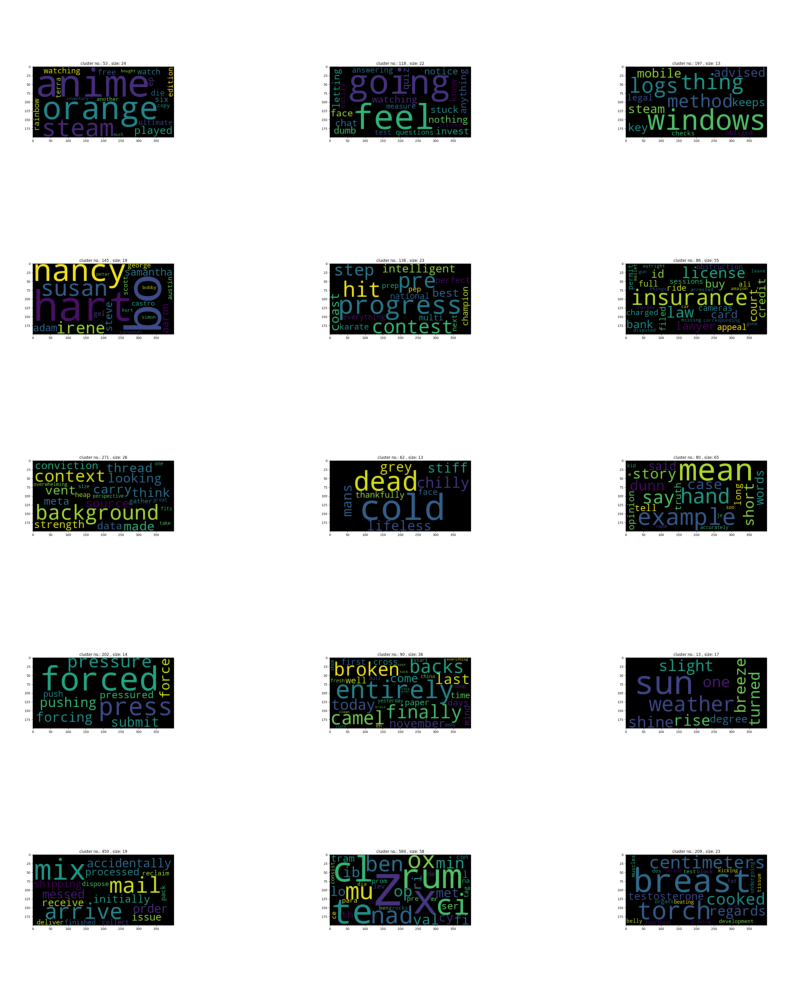

In [46]:
image_paths = [
    f'word_clouds/cosine/average/600/clus_{clusternum.split("_")[1]}.png' for (clusternum, _) in posconceptscoresnegdata[:15]
]
load_concept_wordcloud(image_paths)

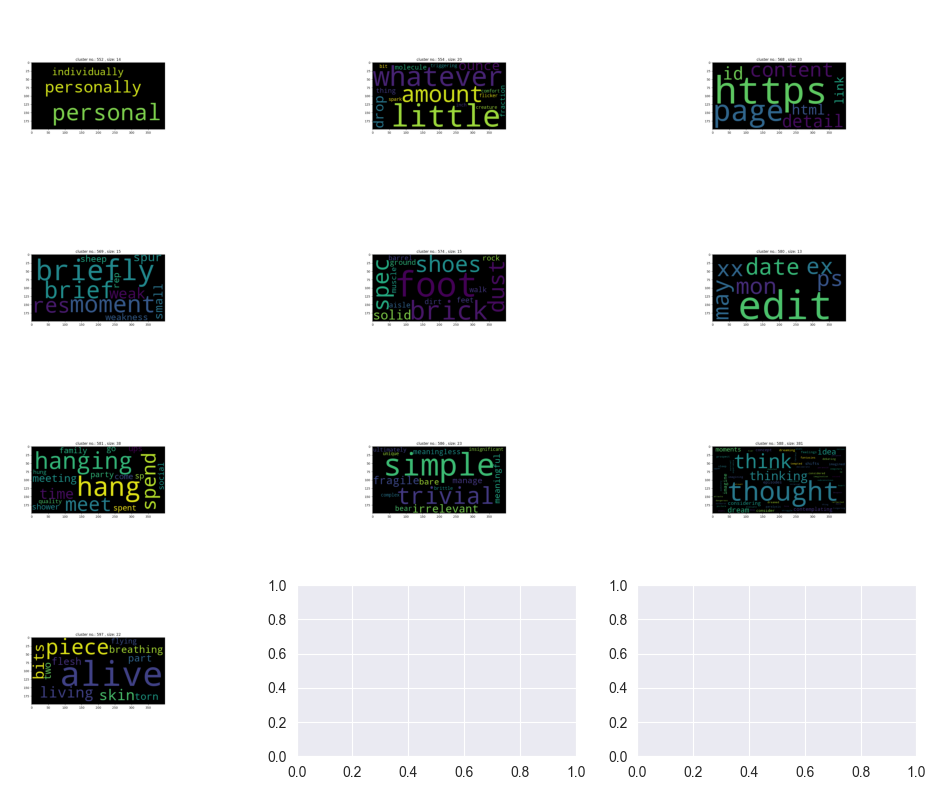

In [47]:
image_paths = [
    f'word_clouds/cosine/average/600/clus_{clusternum.split("_")[1]}.png' for (clusternum, _) in posconceptscoresnegdata[-10:]
]
load_concept_wordcloud(image_paths)

# Ablation

## Load model and Data

In [16]:
from transformers import AutoConfig

model = TextClassificationModel(768, 2)
model.load_state_dict(torch.load(os.path.join(files_dir,f"models/bert_suicide_BCELoss_27June.pt")));
# config = AutoConfig.from_pretrained('bert-base-uncased', num_labels=2)
# config.architectures = ["BertForSequenceClassification"]  # Add this
#
# model = TextClassificationModel(config)
# model.load_state_dict(torch.load(os.path.join(files_dir, f"models/bert_suicide_BCELoss_27June.pt")))
model.to(device);


embedding dimension 768


In [17]:
data = pd.read_csv(os.path.join(files_dir,"suicide/Suicide_Detection.csv"), index_col=0)
data.head(2)

,text,class
2,Ex Wife Threatening SuicideRecently I left my ...,suicide
3,Am I weird I don't get affected by compliments...,non-suicide


In [18]:
data['label'] = (data['class']=='suicide').astype('Int64')
X= np.array(data['text'])
y = np.array(data['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, shuffle=True, stratify= y, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((185659,), (185659,), (46415,), (46415,))

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation=True, max_length=512)
def bert_tokenizer(text: str) -> Tuple[Tensor, Tensor]:
    tokens = tokenizer.__call__(text, return_tensors='pt', padding='max_length', max_length=512, truncation=True)
    words = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])

    return tokens['input_ids'], tokens['attention_mask'], words
def encode_labels(labels) -> Tensor:
    return F.one_hot(torch.tensor([y for y in labels])).to(torch.float32)

In [20]:
X_test_neg = X_test[np.invert(y_test.astype(bool))]
X_test_pos = X_test[y_test.astype(bool)]

In [28]:

start_index=0
end_index = 5000#X_test_neg.shape[0] if X_test_neg.shape[0] < X_test_pos.shape[0] else X_test_pos.shape[0]
def prepare_no_labels(data,start_idx=None, end_idx=None):
    input_ids = []
    attention_masks = []
    for t in data[start_idx:end_idx]:
        tokens = bert_tokenizer(t)
        input_ids.append(tokens[0])
        attention_masks.append(tokens[1])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    # print(input_ids.shape, attention_masks.shape)
    return (input_ids.to(device), attention_masks.to(device))

neg_ds =prepare_no_labels(X_test_neg, start_index, end_index)
pos_ds =prepare_no_labels(X_test_pos, start_index, end_index)

In [29]:
del data
del X_train
del y_train
gc.collect()

102936

In [30]:
def normalize_2d(matrix):
    norm = np.linalg.norm(matrix)
    matrix = matrix/norm  # normalized matrix
    return matrix

In [53]:
# # load_cavs
# pcavs = pd.read_csv("positive_cavs.csv")
# print(pcavs.shape)
# pcavs.head(2)

In [54]:
# tcav = TCAV(model, layers=['bert.encoder.layer.11']) #get gradient



In [22]:
concept_df = pd.read_csv(os.path.join(files_dir,"clustering_results/pos_concepts.csv"))
concept_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,token,sentence,cluster
0,0.092361,0.537579,-0.108185,-0.369392,0.656724,1.118478,-0.146349,-0.118915,0.962345,-1.016192,...,0.525619,-0.005307,-0.348388,0.378788,0.571991,0.303386,0.014218,every,every little problem makes me want to kill my...,338
1,0.023838,0.095783,-0.089390,-0.010807,0.186203,0.555168,0.653269,-0.773034,-0.557048,-0.434466,...,-0.067425,-0.322750,-0.682568,-0.405120,-0.133127,0.074864,-0.234065,little,every little problem makes me want to kill my...,184


In [39]:
concept_df.groupby(['cluster'])['token'].count().sort_values(ascending=False)

cluster
144    3899
295    2439
8      2319
41     2080
274    1962
       ... 
511       1
521       1
537       1
557       1
599       1
Name: token, Length: 600, dtype: int64

In [40]:
concept_df[concept_df['cluster']==338]['token'].unique()

array(['every', 'almost', 'need', 'got', 'maybe', 'tired', 'constantly',
       'te', 'casual', 'moving', 'please', 'suffer', 'bullet', 'constant',
       'people', 'help', 'found', 'intelligence', 'reducing', 'probably',
       'today', 'two', 'seeing', 'da', 'feeling', 'hate', 'year', 'still',
       'sigh', 'losing', 'wish', 'really', 'success', 'week', 'hurting',
       'update', 'pl', 'received', 'nobody', 'everyday', 'girl', 'took',
       'desperately', 'doubtful', 'thinking', 'realizing', 'suicidal',
       'bullshit', 'ah', 'finally', 'define', 'society', 'falsely',
       'real', 'used', 'dying', 'feels', 'failure', 'accidents', 'best',
       'stuck', 'currently', 'h', 'well', 'yeah', 'someone'], dtype=object)

In [48]:

def get_concept_tokens(concept_df, topconcepts):
    concept_tokens = []
    for concept in topconcepts.keys():
        # print(concept_df[concept_df['cluster'] == int(concept)]['token'].unique())
        concept_tokens.extend(concept_df[concept_df['cluster'] == int(concept)]['token'].unique())
    return concept_tokens

topcount = 30

topconcepts = {clusternum.split("_")[1]: score for (clusternum, score) in posconceptscoresposdata[:topcount]}


leastconcepts = {clusternum.split("_")[1]: score for (clusternum, score) in posconceptscoresposdata[-1*topcount:]}


# topconcepts = {clusternum.split("_")[1]: score for (clusternum, score) in posconceptscoresposdata[:topcount] if len(get_concept_tokens(concept_df, {int(clusternum.split("_")[1]):0}))>10}

print(topconcepts)
concept_token_dict = {int(clusternum): [token for token in concept_df[concept_df['cluster']==int(clusternum)]['token'].unique()] for clusternum in topconcepts}




leastconcept_tokens = get_concept_tokens(concept_df, leastconcepts)
leastconcept_tokens = list(set(leastconcept_tokens))


topconcept_tokens = get_concept_tokens(concept_df, topconcepts)
topconcept_tokens = list(set(topconcept_tokens))
len(topconcept_tokens), topconcept_tokens




{'144': 0.3557956777996071, '8': 0.31404715127701377, '295': 0.2957760314341847, '292': 0.29282907662082514, '109': 0.26345776031434187, '293': 0.24970530451866405, '4': 0.24518664047151276, '41': 0.24332023575638506, '44': 0.23664047151277015, '69': 0.23595284872298625, '274': 0.2343811394891945, '248': 0.22347740667976423, '17': 0.21326129666011787, '129': 0.2118860510805501, '106': 0.2087426326129666, '5': 0.206090373280943, '52': 0.20392927308447936, '282': 0.20343811394891945, '344': 0.20294695481335953, '219': 0.20245579567779962, '157': 0.2013752455795678, '3': 0.19607072691552063, '27': 0.193811394891945, '11': 0.1919449901768173, '101': 0.19115913555992142, '588': 0.18958742632612965, '76': 0.18791748526522592, '137': 0.18585461689587426, '66': 0.18536345776031435, '120': 0.18536345776031435}


(2659,
 ['insult',
  'fights',
  'texted',
  'feels',
  'sorry',
  'senior',
  'deal',
  'second',
  'online',
  'husband',
  'smiled',
  'helpful',
  'ever',
  'ir',
  'seemed',
  'autism',
  'ky',
  'cursed',
  'partners',
  'used',
  'troubles',
  'professional',
  'achieve',
  'addiction',
  'alternate',
  'swallowing',
  'tease',
  'duty',
  'pit',
  'sometime',
  'remembers',
  'someone',
  'borrow',
  'compelling',
  'instinct',
  'five',
  'co',
  'knife',
  'hearing',
  'driven',
  'get',
  'survivor',
  'pry',
  'cu',
  'information',
  'educated',
  'communication',
  'unreasonable',
  'suppressed',
  'drugs',
  'freaked',
  'stopping',
  'stupid',
  'utterly',
  'whispering',
  'wonderful',
  'managers',
  'bitter',
  'vale',
  'farther',
  'dirty',
  'yelling',
  'unlimited',
  'meantime',
  'stated',
  'put',
  'bullshit',
  'marry',
  'grief',
  'atm',
  'pressure',
  'competitive',
  'nasty',
  'stronger',
  'pay',
  'basic',
  'grandparents',
  'lu',
  'exist',
  'earn

In [44]:
len(leastconcept_tokens)

582

## inital prediction accuracy

In [49]:
def predict_batches(clf, samples):
    all_preds = []
    len_test = len(samples)
    # print(len_test)
    for batch in samples:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        # print(len(b_input_ids))
        # b_labels = batch[2].to(device)
        # print(b_labels)
        with torch.no_grad():
            out = clf(b_input_ids.cuda(), b_input_mask.cuda())
        all_preds.append(out.cpu().numpy())
        # if idx == 2:
        #     break
    return  all_preds

In [55]:
pos_dataset = torch.utils.data.TensorDataset(pos_ds[0].to(device), pos_ds[1].to(device))
neg_dataset = torch.utils.data.TensorDataset(neg_ds[0].to(device), neg_ds[1].to(device))

In [56]:
test_dataloader_pos = DataLoader(
            pos_dataset,
            sampler = None, 
            batch_size = 64, 
            shuffle=False
            # num_workers= 4
        )
test_dataloader_neg = DataLoader(
            neg_dataset,
            sampler = None, 
            batch_size = 64, 
            shuffle=False
            # num_workers= 4
        )

In [30]:
gc.collect()


100438

In [31]:
model.eval()
pos_predictions = predict_batches(model, test_dataloader_pos)
neg_predictions = predict_batches(model, test_dataloader_neg)

In [32]:
pos_acc = np.mean([x==1 for x in np.argmax(np.vstack(pos_predictions), axis=1)])
neg_acc = np.mean([x==0 for x in np.argmax(np.vstack(neg_predictions), axis=1)])

pos_acc, neg_acc

(0.982, 0.964)

## Removing Top Concept Tokens

In [50]:

# print(topconcept_tokens[0])
#remove_tokens  
# topconcept_tokens_ids, _, topconcept_tokens_words = bert_tokenizer(topconcept_tokens[0])

# print(topconcept_tokens_ids)
# print(topconcept_tokens_words)

# topconcept_tokens_ids = list(set(torch.cat(topconcept_tokens_ids['input_ids'])))
# X_test_pos_removed = []



start_index=0
end_index = X_test_neg.shape[0] if X_test_neg.shape[0] < X_test_pos.shape[0] else X_test_pos.shape[0]
def prepare_no_labels_remove(data,topconcept_tokens, start_idx=None, end_idx=None):
    removed_count = []
    input_ids = []
    attention_masks = []
    
    for t in data[start_idx:end_idx]:
        # print(f"original: {t}")
        removed_count.append(len([w for w in t.split() if w in topconcept_tokens]))
        t_removed =" ".join([w for w in t.split() if w not in topconcept_tokens])
        # print(f"romoved:{len([w for w in t.split() if w in topconcept_tokens])}, _____{[w for w in t.split() if w in topconcept_tokens]}_____ {t_removed}")
        tokens = bert_tokenizer(t_removed)
        input_ids.append(tokens[0])
        # print(input_ids)
        # print("-----------------")
        attention_masks.append(tokens[1])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    # print(input_ids.shape, attention_masks.shape)
    return (input_ids.to(device), attention_masks.to(device)), removed_count

# neg_ds_removed, neg_removed_count  =prepare_no_labels_remove(X_test_neg, topconcept_tokens, start_index, end_index)
pos_ds_removed, pos_removed_count =prepare_no_labels_remove(X_test_pos, topconcept_tokens, start_index, end_index)



In [51]:

pos_removed_count

[3,
 80,
 39,
 48,
 18,
 5,
 17,
 32,
 654,
 2,
 17,
 13,
 47,
 29,
 17,
 39,
 39,
 5,
 124,
 20,
 1,
 54,
 10,
 81,
 192,
 134,
 5,
 12,
 77,
 35,
 193,
 23,
 36,
 28,
 16,
 72,
 19,
 7,
 33,
 40,
 6,
 56,
 61,
 37,
 47,
 17,
 11,
 291,
 36,
 10,
 53,
 10,
 51,
 40,
 36,
 28,
 217,
 10,
 62,
 37,
 75,
 210,
 0,
 27,
 228,
 1,
 41,
 68,
 49,
 10,
 24,
 76,
 65,
 34,
 23,
 43,
 14,
 147,
 12,
 40,
 33,
 10,
 9,
 129,
 6,
 175,
 48,
 28,
 40,
 22,
 17,
 66,
 25,
 33,
 50,
 68,
 25,
 53,
 17,
 14,
 37,
 95,
 299,
 11,
 181,
 11,
 15,
 12,
 28,
 144,
 40,
 5,
 22,
 23,
 64,
 67,
 9,
 11,
 13,
 14,
 112,
 26,
 37,
 28,
 49,
 39,
 31,
 26,
 11,
 79,
 146,
 125,
 76,
 86,
 5,
 150,
 8,
 33,
 7,
 12,
 98,
 88,
 7,
 86,
 62,
 10,
 90,
 45,
 17,
 25,
 154,
 7,
 20,
 22,
 18,
 24,
 51,
 21,
 67,
 82,
 156,
 23,
 5,
 18,
 354,
 86,
 77,
 55,
 39,
 41,
 27,
 6,
 13,
 47,
 143,
 56,
 152,
 14,
 73,
 21,
 101,
 69,
 123,
 24,
 87,
 14,
 16,
 115,
 33,
 48,
 95,
 193,
 50,
 88,
 174,
 66,
 2,
 27,
 4,

In [52]:
np.mean(pos_removed_count)

56.88119963804024

## New Accuracy (after removing tokens)

In [53]:
pos_dataset_removed = torch.utils.data.TensorDataset(pos_ds_removed[0].to(device), pos_ds_removed[1].to(device))
# neg_dataset_removed = torch.utils.data.TensorDataset(neg_ds_removed[0].to(device), neg_ds_removed[1].to(device))

In [54]:
test_dataloader_pos_removed = DataLoader(
            pos_dataset_removed,
            sampler = None, 
            batch_size = 64, 
            shuffle=False
            # num_workers= 4
        )
# test_dataloader_neg_removed = DataLoader(
#             neg_dataset_removed,
#             sampler = None, 
#             batch_size = 64, 
#             shuffle=False
#             # num_workers= 4
#         )

In [55]:
model.eval()
pos_predictions_removed = predict_batches(model, test_dataloader_pos_removed)
# neg_predictions_removed = predict_batches(model, test_dataloader_neg_removed)

In [56]:
pos_acc_removed = np.mean([x==1 for x in np.argmax(np.vstack(pos_predictions_removed), axis=1)])
# neg_acc_removed = np.mean([x==0 for x in np.argmax(np.vstack(neg_predictions_removed), axis=1)])

pos_acc_removed
# , neg_acc_removed

0.9603998793467489

1 concepts: 40 tokens removed on average

In [105]:

# Save the array to a .csv file
np.savetxt(f'ablation_results/pos_predictions_removedcount_concepts_{topcount}{extra_settings}.csv', pos_removed_count,delimiter=',', fmt='%d') 
np.savetxt(f'ablation_results/pos_predictions_concepts_{topcount}{extra_settings}.csv', np.argmax(np.vstack(pos_predictions_removed), axis=1), delimiter=',', fmt='%d')
# np.savetxt(f'ablation_results/neg_predictions_concepts{topcount}.csv', np.argmax(np.vstack(neg_predictions_removed), axis=1), delimiter=',', fmt='%d')

In [ ]:
import seaborn as sns

In [313]:
np.array(pos_removed_count)[np.invert(np.argmax(np.vstack(pos_predictions_removed), axis=1).astype(int).astype(bool))]

array([  1,   0,  24,   2,  10,  34,   7,  16,  12,  10,   2, 108,  27,
        17,  10,  14,   0,   5,   6,  12,   3,   5,   8,  14,   9,  48,
         1,   7,  13,  21,   9])

In [314]:
(pos_removed_count[np.invert(np.argmax(np.vstack(pos_predictions_removed), axis=1).astype(int).astype(bool))])

TypeError: only integer scalar arrays can be converted to a scalar index

<Axes: >

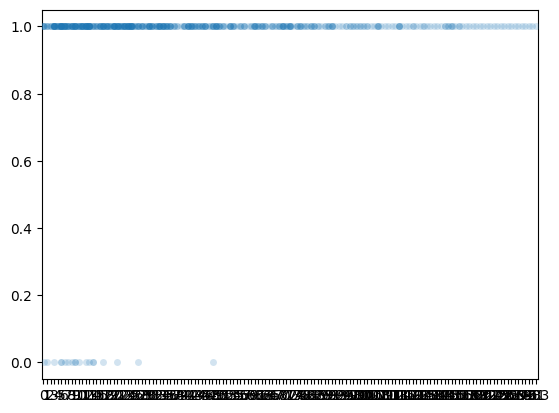

In [315]:
sns.stripplot( x= np.array(pos_removed_count)[500:1000], y = np.argmax(np.vstack(pos_predictions_removed)[500:1000], axis=1), alpha=0.2           )

In [63]:
accs = [0.9857801525401818, 0.9867801525401818, 0.9832801525401818, 0.9827801525401818, 0.9817801525401818, 0.9807801525401818, 0.9862110570086612, 0.9812110570086612]
np.mean(accs),np.std(accs), len(accs)

(0.9835753786573016, 0.002219912431833568, 8)

saving preds

## Removing random tokens

In [40]:
random1 = ["ants", "probable", "shiver", "table", "exuberant", "roll", "vigorous", "mash", " spoil", "encouraging", "bun", "ball", "continue", "neck", "attempt", "abject", "pull", "squealing", "plead", "pretend", "land", "screw", "hide", "distinct", "cleave", "oblige", "look", "decision", "woman", "responsible", "capricious", "cover", "sneeze", "shiver", "houses", "back", "selection", "cleave", "noiseless", "religion", "stimulate", "familiar", "thrust", "jobless", "fat", "way", "immure", "news", "battle", "milk", "think", "letters", "tested", "win", "light", "scary", "young", "saturate", "yield", "shun", "geese", "observe", "calendar", "downtown", "kid", "hen", "disobey", "hurried", "abiding", "toes", "fight", "bread", "fix", "enlighten", "coherent", "arm", "order", "sate", "worm", "oil", "dress", "spend", "tightfisted", "straight", "sheet", "induce", "omniscient", "guiltless", "kite", "input", "confess", "slide", "potato", "park", "brainy", "heart", "trampl", "tan", "blue-eyed", "magnificent", "square", "damaged", "cub", "paper", "shun", "crave", "survey", "damp", "bells", "future", "indicate", "confess", "typical", "vacuous", "trite", "ride", "riddle", "quiver", "solve", "lie", "north", "disturb", "parsimonious", "colorful", "wet", "body", "bend", "pink", "foretell", "lip", "crush", "futuristic", "start", "frightened", "efficient", "sew", "climb", "button", "imperfect", "pass", "swell", "lewd", "attack", "waste", "trucks", "color", "found", "peace", "beg", "fowl", "ray", "yard", "fry", "dinosaurs", "dedicate", "inhale", "develop", "courageous", "afterthought", "deer", "swift", "govern", "angry", "snail", "decisive", "rampant", "tax", "forecast", "sock", "arch", "frequent", "dog", "vase", "teach", "gainsay", "split", "ocean", "laughable", "warlike", "rebel", "twig", "four", "guard", "necessary", "sate", "beds", "decorate", "lacking", "relax", "hiss", "zinc", "stranger", "tightfisted", "hide", "thank", "impair", "cultured", "north", "identify", "fabulous", "walk", "dry", "argument", "scrawny", "realize", "unknown", "respect", "toothsome", "prickly", "smell", "hysterical", "rural", "prescribe", "ignorant", "search", "nutty", "crush", "prepare", "cannon", "thing", "bite-sized", "underwear", "uneven", "jazzy", "glib", "contend", "embarrassed", "powerful", "deranged", "abiding", "staking", "trampl", "string", "dogs", "conduct", "crack", "dwell", "hydrant", "get", "clammy", "busy", "secretary", "forgive", "exchange", "slide", "aboard", "cloistered", "grade", "stream", "fold", "point", "adaptable", "reading", "humdrum", "busy", "quiver", "baby", "teeny", "high", "crooked", "control", "ashamed", "protect", "park", "sisters", "succinct", "discussion", "like", "feet", "low", "waggish", "organic", "hydrant", "different", "pest", "cooperative", "diminish", "favour", "back", "reach", "jazzy", "pointless", "expand", "ache", "imprint", "page", "sample", "reset", "counsel", "carriage", "confiscate", "impulse", "misty", "gray", "direct", "manage", "magnify", "hilarious", "scrub", "wren", "admit", "flimsy", "opposite", "prison", "hole", "like", "haircut", "death", "chip", "signal", "thick", "preserve", "prevent", "gruesome", "ajar", "swallow", "part", "enjoy", "maddening", "obtainable", "trip", "inhabit", "lead", "challenge", "dull", "glow", "ill-informed", "lip", "wring", "prove", "mark", "terminate", "vie", "goldfish", "fallacious", "yawn", "natural", "collect", "expand", "handsomely", "agreeable", "crate", "belligerent", "stick", "inaugurate", "room", "invite", "delicate", "amused", "friends", "low", "charge", "trains", "bottle", "giraffe", "bat", "rhetorical", "smash", "sordid", "chunky", "suffer", "tin", "push", "blur", "foregoing", "powerful", "calculating", "lethal", "afternoon", "chickens", "share", "blush", "blow", "crush", "remain", "lush", "sister", "table", "exultant", "root", "history", "vengeful", "include", "cluttered", "watery", "drug", "bell", "wed", "afford", "judge", "true", "recollect", "sever", "dog", "protest", "thrill", "weak", "kettle", "lazy", "phobic", "thunder", "brave", "ant", "knock", "complete", "easy", "credit", "reflective", "transfer", "farm", "sneeze", "do", "work", "uncle", "diligent", "scan", "real", "arrogant", "skin", " spoil", "drunk", "damp", "merciful", "spotty", "crown", "badge", "credit", "onerous", "monkey", "owe", "regard", "ooze", "screw", "walk", "jazzy", "belief", "fact", "driving", "abandoned", "banana", "jump", "scandalous", "lying", "knock", "convey", "secure", "statuesque", "amazing", "writing", "amusement", "spread", "railway", "driving", "surprise", "bomb", "tree", "graceful", "fierce", "notebook", "market", "convey", "shop", "two", "known", "historical", "reach", "encroach", "body", "frog", "blur", "silky", "scan", "flock", "greedy", "run", "fan", "question", "idolize", "whole", "stem", "zoo", "thankful", "pull", "changeable", "govern", "week", "event", "bow", "refer", "engrave", "judge", "confuse", "foamy", "pencil", "smooth", "cut", "sanctify", "impair", "parallel", "belong", "aback", "tank", "protect", "digestion", "godly", "daughter", "baby", "sash", "brief", "striped", "dynamic", "structure", "square", "shiny", "relax", "survey", "co-operate", "cushion", "word", "fifth", "typeset", "banish", "stitch", "direction", "scold", "hobbies", "note", "edge", "matter", "bash", "parcel", "sister", "moon", "elfin", "sort", "real", "powerful", "mislead", "bikes", "filthy", "notify", "crush", "bulb", "insurance", "combative", "tasty", "waggish", "painful", "respect", "opinion", "energetic", "false", "rely", "false", "direful", "breath", "implode", "women", "treat", "clutch", "decorous", "difficult", "dive", "fast", "pail", "burst", "surmise", "mother", "present", "range", "ruthless", "nappy", "baseball", "hiss", "tacit", "dinosaurs", "hole", "many", "refuse", "whip", "behold", "quince", "holistic", "luxuriant", "induce", "square", "jar", "forbid", "tremble", "mailbox", "imply", "wax", "idolize", "spin", "courageous", "smoke", "reminiscent", "wake", "contemn", "breakfast", "silly", "hate", "shiver", "long", "return", "wasteful", "work", "bucket", "meaty", "omit", "amount", "bomb", "open", "secretary", "beef", "nod", "sister", "frantic", "caring", "reward", "understood", "sticky", "car", "rebel", "bag", "slimy", "animated", "home", "belligerent", "zebra", "butter", "belong", "sparkling", "halting", "burly", "spit", "park", "water", "scrawl", "neat", "nation", "amusing", "bite-sized", "misuse", "guiltless", "creep", "coast", "colorful", "hilarious", "structure", "let", "fang", "flaky", "sable", "purpose", "slope", "subtract", "petite", "toy", "deadpan", "serious", "type", "carriage", "brother", "impair", "broken", "fluttering", "transfer", "determine", "pathetic", "frail", "first", "lowly", "government", "wiggly", "fall", "exist", "broken", "ferry", "maid", "dash", "important", "uncle", "cellar", "yarn", "tail", "grandiose", "impossible", "abusive", "notebook", "rude", "year", "interest", "whispering", "soothe", "cub", "course", "axiomatic", "contrast", "drag", "tongue", "slave", "town", "locket", "week", "cope", "mature", "light", "roasted", "spotless", "rainy", "underwear", "tend", "ancient", "fang", "drag", "kiss", "jealous", "spring", "road", "parallel", "sparkling", "adhesive", "hush", "salve", "story", "convey", "effect", "insurance", "messy", "dare", "plant", "memory", "moldy", "steadfast", "wake", "acrid", "bikes", "congratulate", "harmony", "decrease", "silk", "leap", "caption", "convene", "well-to-do", "collapse", "noxious", "acoustic", "subdued", "insect", "cannon", "beseech"]
random1 = [x.strip() for x in random1]

In [45]:
random2 = pd.read_csv("random_text.csv", header=None)
random2.head()
random2 = [x.replace("\"", "").replace(" ", "") for x in list(random2[0])]
random2

['blue-eyed',
 'store',
 'pass',
 'verse',
 'recite',
 'rest',
 'festive',
 'cart',
 'implant',
 'march',
 'preside',
 'pen',
 'important',
 'extend',
 'cowardly',
 'wring',
 'crown',
 'card',
 'hole',
 'humiliate',
 'toothbrush',
 'boundless',
 'juice',
 'impartial',
 'functional',
 'sit',
 'voracious',
 'measure',
 'immerse',
 'clumsy',
 'box',
 'sting',
 'impossible',
 'attraction',
 'serious',
 'needy',
 'drop',
 'old-fashioned',
 'abstracted',
 'ignite',
 'brick',
 'colorful',
 'plan',
 'solve',
 'notebook',
 'cautious',
 'third',
 'gigantic',
 'modify',
 'fruit',
 'door',
 'awful',
 'toy',
 'merge',
 'productive',
 'float',
 'leer',
 'plastic',
 'handle',
 'chain',
 'sisters',
 'iron',
 'overflow',
 'distance',
 'utter',
 'fabulous',
 'debonair',
 'slim',
 'dust',
 'large',
 'sort',
 'swift',
 'disillusioned',
 'first',
 'upbeat',
 'parched',
 'wide',
 'quilt',
 'arch',
 'various',
 'jeans',
 'lavish',
 'record',
 'sash',
 'oval',
 'soup',
 'anxious',
 'leg',
 'betray',
 'clutch'

In [46]:
remove_counts = np.loadtxt(f'E_Experiment results/ablation_results/pos_predictions_removedcount_concepts_{topcount}{extra_settings}.csv', delimiter=',') 

In [38]:
len(random2)

3246

In [41]:
len(random1)

753

In [24]:
topcount

30

In [23]:
remove_counts = remove_counts.astype(int)

In [29]:
remove_counts

array([ 3, 80, 39, ...,  9, 19, 56])

In [66]:


start_index=0
end_index = X_test_neg.shape[0] if X_test_neg.shape[0] < X_test_pos.shape[0] else X_test_pos.shape[0]
def prepare_no_labels_removerandom(data, topconcept_tokens, start_idx=None, end_idx=None):
    removed_count = []
    input_ids = []
    attention_masks = []
    i=0
    for t in data[start_idx:end_idx]:
        # print(t)
        # removed_count.append(len([w for w in t.split() if w in topconcept_tokens]))
        # removed_words = random.sample(topconcept_tokens, count_remove)
        t_removed =" ".join([w for w in t.split() if w not in topconcept_tokens])
        # t_removed = " ".join(random.sample(t.split(), len(t.split())-count_remove[i]))
        # print(t_removed)
        tokens = bert_tokenizer(t_removed)
        input_ids.append(tokens[0])
        # print(input_ids)
        # print("-----------------")
        attention_masks.append(tokens[1])
        i+=1
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    # print(input_ids.shape, attention_masks.shape)
    return (input_ids.to(device), attention_masks.to(device))


# pos_ds_random =prepare_no_labels_removerandom(X_test_pos,remove_counts, random2, start_index, end_index)
pos_ds_random =prepare_no_labels_removerandom(X_test_pos, leastconcept_tokens, start_index, end_index)



# def prepare_no_labels_removerandom(data,topconcept_tokens, start_idx=None, end_idx=None):
#     removed_count = []
#     lens=[]
#     input_ids = []
#     attention_masks = []
#     for t in data[start_idx:end_idx]:
#         # print(t)
#         # removed_count.append(len([w for w in t.split() if w in topconcept_tokens]))
#         lens.append(len(t.split()))
#         t_removed =" ".join([w for w in t.split()][:20])

#         # t_removed =" ".join([w for w in t.split() if w not in topconcept_tokens][:20])
#         # print(t_removed)
#         tokens = bert_tokenizer(t_removed)
#         input_ids.append(tokens[0])
#         # print(input_ids)
#         # print("-----------------")
#         attention_masks.append(tokens[1])
#     input_ids = torch.cat(input_ids, dim=0)
#     attention_masks = torch.cat(attention_masks, dim=0)
#     # print(input_ids.shape, attention_masks.shape)
#     return (input_ids.to(device), attention_masks.to(device)), lens

# neg_ds_random, pos_lens =prepare_no_labels_removerandom(X_test_neg, random1, start_index, end_index)
# pos_ds_random, neg_lens =prepare_no_labels_removerandom(X_test_pos, random1, start_index, end_index)


### visuallising distributions 

In [ ]:
# import seaborn as sns

(<Axes: >, 41.954070981210855)

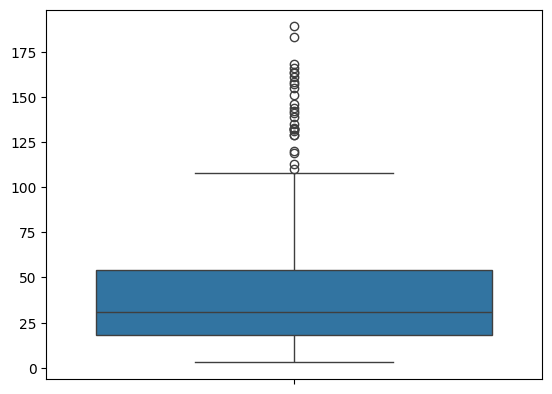

In [ ]:
# sns.boxplot([x for x in pos_lens if x<200]), np.mean([x for x in pos_lens if x<200])

## Random Accuracy (after removing Random tokens)

In [67]:
pos_dataset_random = torch.utils.data.TensorDataset(pos_ds_random[0].to(device), pos_ds_random[1].to(device))
# neg_dataset_random = torch.utils.data.TensorDataset(neg_ds_random[0].to(device), neg_ds_random[1].to(device))

test_dataloader_pos_random = DataLoader(
            pos_dataset_random,
            sampler = None, 
            batch_size = 64, 
            shuffle=False
            # num_workers= 4
        )
# test_dataloader_neg_random = DataLoader(
        #     neg_dataset_random,
        #     sampler = None, 
        #     batch_size = 64, 
        #     shuffle=False
        #     # num_workers= 4
        # )

model.eval()
pos_predictions_random = predict_batches(model, test_dataloader_pos_random)
# neg_predictions_random = predict_batches(model, test_dataloader_neg_random)

pos_acc_random = np.mean([x==1 for x in np.argmax(np.vstack(pos_predictions_random), axis=1)])
# neg_acc_random = np.mean([x==0 for x in np.argmax(np.vstack(neg_predictions_random), axis=1)])

pos_acc_random
# , neg_acc_random

0.9766018873615719

In [68]:
topcount

100

In [ ]:

# Save the array to a .csv file
np.savetxt(f'ablation_results/pos_predictions_random_{topcount}.csv', np.argmax(np.vstack(pos_predictions_random), axis=1), delimiter=',', fmt='%d')
# np.savetxt(f'ablation_results/neg_predictions_random_{topcount}.csv', np.argmax(np.vstack(neg_predictions_random), axis=1), delimiter=',', fmt='%d')

In [32]:
np.loadtxt('ablation_results/neg_predictions_random_10.csv',delimiter=',').sum()

1099.0

# Injection

In [224]:
set("hello").intersection("a")

set()

## Adding Top positive Concept Tokens to negative samples

In [58]:
start_index=0
end_index = X_test_neg.shape[0] if X_test_neg.shape[0] < X_test_pos.shape[0] else X_test_pos.shape[0]
# def prepare_no_labels_add(data,topconcept_tokens, start_idx=None, end_idx=None):
#     input_ids = []
#     attention_masks = []
#     for t in data[start_idx:end_idx]:
#         # print(t)
#         added_words = " ".join(random.sample(topconcept_tokens, 10))
#         t_added = t + " " + added_words
#         # print(t_removed)
#         tokens = bert_tokenizer(t_added)
#         input_ids.append(tokens[0])
#         # print(input_ids)
#         # print("-----------------")
#         attention_masks.append(tokens[1])
#     input_ids = torch.cat(input_ids, dim=0)
#     attention_masks = torch.cat(attention_masks, dim=0)
#     # print(input_ids.shape, attention_masks.shape)
#     return (input_ids.to(device), attention_masks.to(device))


def prepare_no_labels_add(data,topconcept_tokens,count_add, start_idx=None, end_idx=None):
    input_ids = []
    attention_masks = []
    for t in data[start_idx:end_idx]:
        # print(t)
        chosen_concept = random.sample(list(topconcept_tokens.keys()), 2)
        chosen_tokens = list(np.concatenate([[x for x in concept_token_dict[conc]] for conc in chosen_concept]))
        # count_add =10 #int(0.2 * len(t.split()))
        while len(chosen_tokens)<count_add:
            chosen_concept.append(random.sample(list(topconcept_tokens.keys()), 1)[0])
            chosen_tokens = list(np.concatenate([[x for x in concept_token_dict[conc]] for conc in chosen_concept]))
        added_words = " ".join(random.sample([x for x in chosen_tokens], count_add))

        separators = list(set(t).intersection(".;-,"))
        
        if len(separators)>0:
            insert_position = t.index(separators[0])+1
            t_added =(t[:insert_position]) + " "+ added_words +" . "+ (t[insert_position:]) 

        else:
            t_added = t.split()
            t_added = " ".join(t_added[:len(t_added)//3]) + " . " + added_words[:count_add//2] +" ."+ " ".join(t_added[len(t_added)//3:2*len(t_added)//3]) + " . " + added_words[count_add//2:] +" ."+ " ".join(t_added[2*len(t_added)//3:]) 
        # print(t_added)
        tokens = bert_tokenizer(t_added)
        input_ids.append(tokens[0])
        # print(input_ids)
        # print("-----------------")
        attention_masks.append(tokens[1])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    # print(input_ids.shape, attention_masks.shape)
    return (input_ids.to(device), attention_masks.to(device))

count_add = 25

neg_ds_added  =prepare_no_labels_add(X_test_neg, concept_token_dict,count_add, start_index, end_index)
# pos_ds_added =prepare_no_labels_add(X_test_pos, concept_token_dict, start_index, end_index)



## New Accuracy after adding tokens

In [ ]:
# # pos_dataset_added = torch.utils.data.TensorDataset(pos_ds_added[0].to(device), pos_ds_added[1].to(device))
neg_dataset_added = torch.utils.data.TensorDataset(neg_ds_added[0].to(device), neg_ds_added[1].to(device))

# # test_dataloader_pos_added = DataLoader(
# #             pos_dataset_added,
# #             sampler = None, 
# #             batch_size = 64, 
# #             shuffle=False
# #             # num_workers= 4
# #         )
test_dataloader_neg_added = DataLoader(
            neg_dataset_added,
            sampler = None, 
            batch_size = 64, 
            shuffle=False
            # num_workers= 4
        )

# model.eval()
# # pos_predictions_added = predict_batches(model, test_dataloader_pos_added)
neg_predictions_added = predict_batches(model, test_dataloader_neg_added)

# # np.savetxt(f'injection_results/pos_predictions_concepts{topcount}.csv', np.argmax(np.vstack(pos_predictions_added), axis=1), delimiter=',', fmt='%d')
# np.savetxt(f'injection_results/neg_predictions_concepts{topcount}_added{count_add}{extra_settings}.csv', np.argmax(np.vstack(neg_predictions_added), axis=1), delimiter=',', fmt='%d')

# pos_acc_added = np.mean([x==1 for x in np.argmax(np.vstack(pos_predictions_added), axis=1)])
neg_acc_added = np.mean([x==0 for x in np.argmax(np.vstack(neg_predictions_added), axis=1)])

# print(pos_acc_added)
print(neg_acc_added)

## Adding random tokens

In [50]:
start_index=0
end_index = X_test_neg.shape[0] if X_test_neg.shape[0] < X_test_pos.shape[0] else X_test_pos.shape[0]
def prepare_no_labels_add(data,count_add, topconcept_tokens, start_idx=None, end_idx=None):
    input_ids = []
    attention_masks = []
    for t in data[start_idx:end_idx]:
        # print(t)
        
        added_words = " ".join(random.sample(topconcept_tokens, count_add))

        separators = list(set(t).intersection(".;-,"))
        
        if len(separators)>0:
            insert_position = t.index(separators[0])
            t_added =(t[:insert_position]) + " "+ added_words +" . "+ (t[insert_position:]) 

        else:
            t_added = t.split()
            t_added = " ".join(t_added[:len(t_added)//3]) + " . " + added_words[:count_add//2] +" ."+ " ".join(t_added[len(t_added)//3:2*len(t_added)//3]) + " . " + added_words[count_add//2:] +" ."+ " ".join(t_added[2*len(t_added)//3:])  

        # t_added = t[:len(t)//2] + " " + added_words + " " +  t[len(t)//2:]
        # print(t_removed)
        tokens = bert_tokenizer(t_added)
        input_ids.append(tokens[0])
        # print(input_ids)
        # print("-----------------")
        attention_masks.append(tokens[1])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    # print(input_ids.shape, attention_masks.shape)
    return (input_ids.to(device), attention_masks.to(device))

neg_ds_randomadded  =prepare_no_labels_add(X_test_neg,20, random2, start_index, end_index)
# pos_ds_randomadded =prepare_no_labels_add(X_test_pos, random1, start_index, end_index)



## New Accuracy after adding random tokens

In [51]:
# pos_dataset_randomadded = torch.utils.data.TensorDataset(pos_ds_randomadded[0].to(device), pos_ds_randomadded[1].to(device))
neg_dataset_randomadded = torch.utils.data.TensorDataset(neg_ds_randomadded[0].to(device), neg_ds_randomadded[1].to(device))

# test_dataloader_pos_randomadded = DataLoader(
#             pos_dataset_randomadded,
#             sampler = None, 
#             batch_size = 64, 
#             shuffle=False
#             # num_workers= 4
        # )
test_dataloader_neg_randomadded = DataLoader(
            neg_dataset_randomadded,
            sampler = None, 
            batch_size = 64, 
            shuffle=False
            # num_workers= 4
        )

model.eval()
# pos_predictions_randomadded = predict_batches(model, test_dataloader_pos_randomadded)
neg_predictions_randomadded = predict_batches(model, test_dataloader_neg_randomadded)

# np.savetxt(f'injection_results/pos_predictions_concepts{topcount}.csv', np.argmax(np.vstack(pos_predictions_randomadded), axis=1), delimiter=',', fmt='%d')
# np.savetxt(f'injection_results/neg_predictions_concepts{topcount}.csv', np.argmax(np.vstack(neg_predictions_randomadded), axis=1), delimiter=',', fmt='%d')

# pos_acc_randomadded = np.mean([x==1 for x in np.argmax(np.vstack(pos_predictions_randomadded), axis=1)])
neg_acc_randomadded = np.mean([x==0 for x in np.argmax(np.vstack(neg_predictions_randomadded), axis=1)])

# print(pos_acc_randomadded) 
print(neg_acc_randomadded)

0.9437669668634464


# ConceptSHAP

In [37]:
import json


In [44]:
with open(os.path.join(files_dir,'suicide_concept_words.json'), 'r') as f:
    conceptshap_dict = json.load(f)
topshapconcepts = ([x[0] for xs in list(conceptshap_dict.values()) for x in xs])

In [45]:
print(topshapconcepts)

['i', '.', 'to', ',', "'", '’', 'and', 'a', 'my', 'me', 't', 'the', 'it', 'm', 'just', 'of', 'that', 'but', 'in', 's', 'i', '.', ',', 'the', 'a', 'to', 'and', "'", 'penis', 'bye', 'of', 'cecil', 'my', '*', 'it', 'nostalgia', '’', 'you', 't', 'in', 'i', '.', ',', 'to', 'and', "'", 'my', 'a', 'the', 'of', 'it', 'me', 't', 'that', 'in', 'have', 'for', 'was', 'but', 'm', '.', 'i', ',', '-', 'to', '/', 'and', 'the', 'a', "'", 'of', 'it', 'that', '*', 'you', 'in', 'is', 'my', 't', 'for', 'i', '.', ',', 'to', "'", 'and', 'the', 'a', 'my', 'it', 'of', 'me', 't', 'm', 'that', 'in', '’', 'but', 'is', 'just', 'i', '.', 'you', ',', 'to', 'and', "'", 'a', '’', 'it', 'the', 'my', '[UNK]', 't', 'that', 'me', 'm', '\\', 'of', 'for', 'i', '.', 'to', 'and', 'a', ',', 'the', 'my', "'", 'trapped', 'it', 'im', 'of', 'me', 'o', '##of', 'that', 'you', 'in', 'is', 'i', '.', 'to', "'", 'm', ',', 'and', 't', 'my', 'me', '’', 'a', 'the', 'just', 'it', '?', 'of', 'don', 'want', 'have', '.', 'i', ',', 'the', 'and'

In [46]:
topshapconcepts
from nltk.corpus import stopwords

stop = stopwords.words('english')
print((stop))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [53]:
" ".join(topshapconcepts)

"i . to , ' ’ and a my me t the it m just of that but in s i . , the a to and ' penis bye of cecil my * it nostalgia ’ you t in i . , to and ' my a the of it me t that in have for was but m . i , - to / and the a ' of it that * you in is my t for i . , to ' and the a my it of me t m that in ’ but is just i . you , to and ' a ’ it the my [UNK] t that me m \\ of for i . to and a , the my ' trapped it im of me o ##of that you in is i . to ' m , and t my me ’ a the just it ? of don want have . i , the and to a it my ’ of you he in that ' t was is me . i / ! , you to a ' ? and : the me my it is of just this"

In [ ]:
def save_wordclouds(text, location):
    try:
        os.makedirs(location)
        print(f"Directory '{location}' created successfully.")
    except FileExistsError:
        print(f"Directory '{location}' already exists.")
    except OSError as e:
        print(f"Error creating directory '{location}': {e}")

    try:
        os.makedirs(f"{location}/small")
        print(f"Directory '{location}' created successfully.")
    except FileExistsError:
        print(f"Directory '{location}' already exists.")
    except OSError as e:
        print(f"Error creating directory '{location}': {e}")



        words = list(text)
        try:
            if len(words)>0:
                # print(len(words))
                wc = WordCloud(collocations=False, background_color="white").generate(" ".join(words))
                plt.figure(figsize=(7, 4), facecolor=None)
                plt.title(f"cluster no.: {clus} , size: {len(words)}")
                plt.xticks([])
                plt.yticks([])
                plt.imshow(wc)
                if len(words)>10:
                    plt.savefig(f"{location}/clus_{clus}")
                else:
                    plt.savefig(f"{location}/small/clus_{clus}")

                plt.close()
                # break
        except:
            print(words)

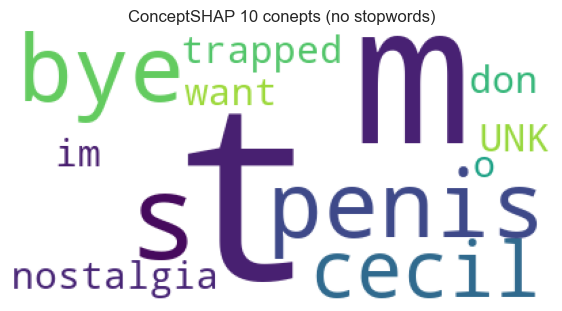

In [70]:
from wordcloud import WordCloud

wc = WordCloud(collocations=False, background_color="white", random_state=42).generate(" ".join(topshapconcepts))
plt.figure(figsize=(7, 4), facecolor=None)


plt.title(f"ConceptSHAP 10 conepts (no stopwords)")
plt.xticks([])
plt.yticks([])
plt.imshow(wc)
plt.savefig(f"conceptSHAP_nostopwords")


In [31]:
# topshapconcepts = set(topshapconcepts)-set(stop) - set(".,-()/>''\"\"<") | set(["the"])


In [47]:

# print(topconcept_tokens[0])
#remove_tokens
# topconcept_tokens_ids, _, topconcept_tokens_words = bert_tokenizer(topconcept_tokens[0])

# print(topconcept_tokens_ids)
# print(topconcept_tokens_words)

# topconcept_tokens_ids = list(set(torch.cat(topconcept_tokens_ids['input_ids'])))
# X_test_pos_removed = []



start_index=0
end_index = 5000#X_test_neg.shape[0] if X_test_neg.shape[0] < X_test_pos.shape[0] else X_test_pos.shape[0]
def prepare_no_labels_remove(data,topconcept_tokens, start_idx=None, end_idx=None):
    removed_count = []
    input_ids = []
    attention_masks = []

    for t in data[start_idx:end_idx]:
        # print(f"original: {t}")
        removed_count.append(len([w for w in t.split() if w in topconcept_tokens]))
        t_removed =" ".join([w for w in t.split() if w not in topconcept_tokens])
        # print(t_removed)
        # print(f"romoved:{len([w for w in t.split() if w in topconcept_tokens])}, _____{[w for w in t.split() if w in topconcept_tokens]}_____ {t_removed}")
        tokens = bert_tokenizer(t_removed)
        input_ids.append(tokens[0])
        # print(input_ids)
        # print("-----------------")
        attention_masks.append(tokens[1])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    # print(input_ids.shape, attention_masks.shape)
    return (input_ids.to(device), attention_masks.to(device)), removed_count

# neg_ds_removed, neg_removed_count  =prepare_no_labels_remove(X_test_neg, topconcept_tokens, start_index, end_index)
pos_ds_removed, pos_removed_count =prepare_no_labels_remove(X_test_pos, topshapconcepts, start_index, end_index)



In [52]:
pos_dataset_removed = torch.utils.data.TensorDataset(pos_ds_removed[0].to(device), pos_ds_removed[1].to(device))
# neg_dataset_removed = torch.utils.data.TensorDataset(neg_ds_removed[0].to(device), neg_ds_removed[1].to(device))
test_dataloader_pos_removed = DataLoader(
            pos_dataset_removed,
            sampler = None,
            batch_size = 64,
            shuffle=False
            # num_workers= 4
        )
# test_dataloader_neg_removed = DataLoader(
#             neg_dataset_removed,
#             sampler = None,
#             batch_size = 64,
#             shuffle=False
#             # num_workers= 4
#         )
model.eval()
pos_predictions_removed = predict_batches(model, test_dataloader_pos_removed)
# neg_predictions_removed = predict_batches(model, test_dataloader_neg_removed)
pos_acc_removed = np.mean([x==1 for x in np.argmax(np.vstack(pos_predictions_removed), axis=1)])
# neg_acc_removed = np.mean([x==0 for x in np.argmax(np.vstack(neg_predictions_removed), axis=1)])

pos_acc_removed
# , neg_acc_removed

C:\Users\salma\AppData\Local\Temp\ipykernel_21668\862246873.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  all_preds.append(F.softmax(out['logits']).cpu().numpy())


0.976